<a href="https://colab.research.google.com/github/cunhamaicon/petr4/blob/master/petr4_rnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PETR4 - RNN2

**Implementação de rede neural recorrente para prever o valor de abertura da ação PETR4 no dia seguinte.**


** Autor: Maicon Henrique Cunha**

Github: [https://github.com/cunhamaicon](https://github.com/cunhamaicon/)

## Informações:

1. Foram coletados dados dos valores de abertura e volume das ações da Petrobras PETR4 desde o momento de seu lançamento na bolsa 03/01/2000 até o dia 15/04/2019. Os dados podem ser obtidos [aqui](https://github.com/cunhamaicon/petr4) no arquivo "PETR4.csv".

2. Nesse segunda rede  (RNN2 ) serão consideradas as variáveis  "abertura" e "volume".

3. Nesse teste foram considerados 100 dias de memória da rede e para comparativo a previsão dos últimos 50 dias do valor da ação.

4. Todo o código foi feito no Colab e pode ser compilado online em [https://colab.research.google.com](https://colab.research.google.com).

## Objetivos:



1.   Tratar os dados
2.   Construção de rede neural recorrente
3. Análise dos resultados
4. Comparação com o comportamento real da ação



##Procedimentos iniciais:

###Fazendo download da pasta:

In [0]:
!git clone https://github.com/cunhamaicon/petr4

fatal: destination path 'petr4' already exists and is not an empty directory.


Mostrando arquivos da pasta:

In [0]:
ls petr4

CrudeOil.csv  PETR4.csv  petr4_rnn1.ipynb  petr4_rnn2.ipynb


###Importação dos pacotes ncessários:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math
from sklearn.metrics import mean_squared_error
import os

###Definição de parâmetros:

1. A variável "size" indica quantos dias anteriores a previsão serão utilizados para treinamento da rede em cada iteração.

2. A variável "date" indica qual o início do período de captção dos dados.
3. A variável "days" indica quantos dias serão objetos de estudo na análise posterior a construção do modelo.
4. A variável "final_date" indica a data do último registro captado.

Obs: as variáveis "date" e "final_date" devem ser escolhidas no formato indicado e devem ser dados válidos. Datas em que não houve registro devem ser desconsideradas. Esse procedimento será feito com a aplicação da função select_date.

In [0]:
size = 100
date = "2000-06-23"
days = 50
final_date = "2019-04-15"

##Pré-processamento de dados:

###Criando o dataset:

In [0]:
datadir='petr4'
dataset = pd.read_csv(os.path.join(datadir, "PETR4.csv"))

Mostrando o cabeçalho do banco:

In [0]:
dataset.head()

,Date,Open,Volume
0,2000-01-03,5.88,3.538944e+10
1,2000-01-04,5.55,2.886144e+10
2,2000-01-05,5.49,4.303360e+10
3,2000-01-06,5.48,3.405568e+10
4,2000-01-07,5.50,2.091264e+10


Confereindo o tamanho do banco:

In [0]:
len(dataset)

4857

### Remoção

Removendo entradas nulas:

In [0]:
dataset = dataset.dropna()

Conferindo o tamanho do banco sem as entradas nulas:

In [0]:
len(dataset)

4737

Remoção de zeros decorrentes de dias em que não houve movimentação:

In [0]:
dataset = dataset.drop(dataset.loc[dataset['Volume']==0].index)

Conferindo o tamanho do banco de dados com dias onde o volume foi diferente de zero:

In [0]:
len(dataset)

4710

### Conferência da data

Definição da função que verifica se a data faz parte do banco de dados:

In [0]:
def select_date(date):
  
  """Dada uma entrada data de entrada verifica se essa data faz parte de dados.
  Caso não faça pede para definir novamente. """
  
  if len(dataset.loc[dataset['Date'] == date])>0:
    return dataset.loc[dataset['Date'] == date].index[0]
  else:
    return print("Insira uma data válida")

Definindo o indice de inicio do banco:

In [0]:
index_select_date = select_date(date)

Definindo o índice do fim do banco:

In [0]:
index_final_date = select_date(final_date)

### Treinamento e Teste

Separando dois bancos, um de treinamento e um de teste:

In [0]:
dataset_train = dataset.iloc[:-days,:]
dataset_test = dataset.iloc[-days:,:]

Separando dados de treinamento e teste:

In [0]:
training_set = dataset_train.iloc[:,1:3].values.astype(float)
test_set = dataset_test.iloc[:,1:3].values.astype(float)

###MinMaxScaler:

Fazendo a transformação dos dados para ficar no intervalo [0,1] :

In [0]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

###X_train e y_train :

Cada ciclo de treinamento deve ter o tamanho "size" definido anteriormente representando as "size" entradas anterioes. O conjunto de treinamento "X_train" deve emparelhar todas essas entradas. "y_train" é a saída da rede, o próximo elemento depois das "size" entradas:

In [0]:
X_train = []
y_train = []
for i in range(size, len(training_set)):
    
    X_train.append(training_set_scaled[i-size:i, :])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
    
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))

## Construindo a RNN

In [0]:
def regressor():
  regressor = Sequential()

  regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))
  regressor.add(Dropout(0.2))

  
  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

 
  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  
  regressor.add(LSTM(units = 50))
  regressor.add(Dropout(0.2))

  
  regressor.add(Dense(units = 1))

 
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
  return regressor

Mostrando as informações da rede:

In [0]:
regressor = regressor()
print(regressor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
__________

### Treinando a rede

In [0]:
history = regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
4560/4560 [==============================] - 40s 9ms/step - loss: 0.0037
Epoch 2/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0015
Epoch 3/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0014
Epoch 4/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0012
Epoch 5/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0011
Epoch 6/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0010
Epoch 7/10
4560/4560 [==============================] - 36s 8ms/step - loss: 0.0010
Epoch 8/10
4560/4560 [==============================] - 37s 8ms/step - loss: 9.4457e-04
Epoch 9/10
4560/4560 [==============================] - 37s 8ms/step - loss: 8.8485e-04
Epoch 10/10
4560/4560 [==============================] - 36s 8ms/step - loss: 8.6803e-04


## Visualização dos resultados

Criando a variável com o valor real da ação:

In [0]:
real_stock_price = dataset_test.iloc[:, 1:2].values.astype(float)


Criando as entradas para visualização dos resultados e fazendo a transformação baseada no conjunto de treinamento:

In [0]:
inputs = dataset.iloc[len(dataset) - len(dataset_test) - size:,1:3].values.astype(float)
inputs = sc.transform(inputs)

Criando a variável de teste:

In [0]:
X_test = []
for i in range(size, size+days):
    X_test.append(inputs[i-size:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

Aplicando a variável de teste na rede treinada anteriormente e fazendo o processo inverso de transformção escalar:

In [0]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = np.concatenate((predicted_stock_price, predicted_stock_price), axis=0)
predicted_stock_price =predicted_stock_price.reshape(days,2)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Como essa rede recorrente possui duas saídas, vamos escolher a saída adequada:

In [0]:
predicted_stock_price=predicted_stock_price[:,0]

Cálculo do erro quadrático médio:

In [0]:
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))


In [0]:
title = 'Preço de abertura de PETR4. RMSE = ' + str(rmse)[:5]

Mostrando o valor real da ação comparado com o valor previsto no período analisado:

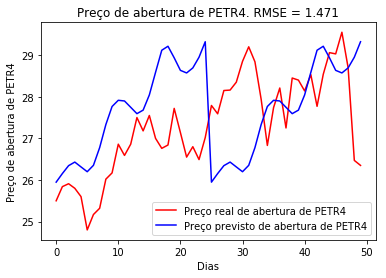

In [0]:
plt.plot(real_stock_price, color = 'red', label = "Preço real de abertura de PETR4")
plt.plot(predicted_stock_price, color = 'blue', label = 'Preço previsto de abertura de PETR4')
plt.title(title)
plt.xlabel('Dias')
plt.ylabel('Preço de abertura de PETR4')
plt.legend()
plt.show()